In [1]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import json
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
#from project import data_preprocessing
from project.model import models
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

%matplotlib inline

Using TensorFlow backend.


In [2]:
from project import config

#### Ready to feed the ANN

In [3]:
xvals = [90, 180, 365, 730, 1095, 1460, 1825, 2190, 2555, 2920, 3285, 3650, 4015, 4380]

def loadData(trainingPercentage = 0.8):
    path_to_cleaned_data_SX5E = config.path_to_cleaned_data_SX5E
    path_to_cleaned_data_NKY = config.path_to_cleaned_data_NKY
    path_to_cleaned_data_SPX = config.path_to_cleaned_data_SPX
    path_to_cleaned_data_UKX = config.path_to_cleaned_data_UKX

    with open(path_to_cleaned_data_SX5E) as json_file:
        dictionary_SX5E = json.load(json_file)
    with open(path_to_cleaned_data_NKY) as json_file:
        dictionary_NKY = json.load(json_file)
    with open(path_to_cleaned_data_SPX) as json_file:
        dictionary_SPX = json.load(json_file)
    with open(path_to_cleaned_data_UKX) as json_file:
        dictionary_UKX = json.load(json_file)
    
    # Interpolating the data
    
    input_vector_SX5E = []
    input_vector_NKY = [] 
    input_vector_SPX = []
    input_vector_UKX = []
    input_vector_SX5E_orig = []
    input_vector_NKY_orig = [] 
    input_vector_SPX_orig = []
    input_vector_UKX_orig = []

    for key in dictionary_SX5E.keys():
        x = dictionary_SX5E[key][0]
        y = dictionary_SX5E[key][1]
        yinterp = np.interp(xvals, x, y)
        #computing new interpolated values
        dictionary_SX5E[key][0] = xvals
        dictionary_SX5E[key][1] = yinterp
        input_vector_SX5E.append(yinterp.tolist())
        input_vector_SX5E_orig.append(pd.Series(y,index=x))

    for key in dictionary_NKY.keys():
        x = dictionary_NKY[key][0]
        y = dictionary_NKY[key][1]
        yinterp = np.interp(xvals, x, y)
        #computing new interpolated values
        dictionary_NKY[key][0] = xvals
        dictionary_NKY[key][1] = yinterp
        input_vector_NKY.append(yinterp.tolist())
        input_vector_NKY_orig.append(pd.Series(y,index=x))

    for key in dictionary_SPX.keys():
        x = dictionary_SPX[key][0]
        y = dictionary_SPX[key][1]
        yinterp = np.interp(xvals, x, y)
        #computing new interpolated values
        dictionary_SPX[key][0] = xvals
        dictionary_SPX[key][1] = yinterp
        input_vector_SPX.append(yinterp.tolist())
        input_vector_SPX_orig.append(pd.Series(y,index=x))

    for key in dictionary_UKX.keys():
        x = dictionary_UKX[key][0]
        y = dictionary_UKX[key][1]
        yinterp = np.interp(xvals, x, y)
        #computing new interpolated values
        dictionary_UKX[key][0] = xvals
        dictionary_UKX[key][1] = yinterp
        input_vector_UKX.append(yinterp.tolist())
        input_vector_UKX_orig.append(pd.Series(y,index=x))
    
        
    # Computing the input_training_set and input_validation_set
    stop_NKY = int(len(input_vector_NKY)*trainingPercentage)
    stop_SPX = int(len(input_vector_SPX)*trainingPercentage)
    stop_SX5E = int(len(input_vector_SX5E)*trainingPercentage)
    stop_UKX= int(len(input_vector_UKX)*trainingPercentage)

    input_training_set_NKY = input_vector_NKY[:stop_NKY]
    input_validation_set_NKY = input_vector_NKY[stop_NKY:]
    input_training_set_SPX = input_vector_SPX[:stop_SPX]
    input_validation_set_SPX = input_vector_SPX[stop_SPX:]
    input_training_set_SX5E = input_vector_SX5E[:stop_SX5E]
    input_validation_set_SX5E = input_vector_SX5E[stop_SX5E:]
    input_training_set_UKX = input_vector_UKX[:stop_UKX]
    input_validation_set_UKX = input_vector_UKX[stop_UKX:]

    input_training_set_NKY_orig = input_vector_NKY_orig[:stop_NKY]
    input_validation_set_NKY_orig = input_vector_NKY_orig[stop_NKY:]
    input_training_set_SPX_orig = input_vector_SPX_orig[:stop_SPX]
    input_validation_set_SPX_orig = input_vector_SPX_orig[stop_SPX:]
    input_training_set_SX5E_orig = input_vector_SX5E_orig[:stop_SX5E]
    input_validation_set_SX5E_orig = input_vector_SX5E_orig[stop_SX5E:]
    input_training_set_UKX_orig = input_vector_UKX_orig[:stop_UKX]
    input_validation_set_UKX_orig = input_vector_UKX_orig[stop_UKX:]
    
    input_training_set = np.vstack((input_training_set_NKY,
                                    input_training_set_SPX,
                                    input_training_set_SX5E,
                                    input_training_set_UKX))
    
    input_validation_set = (input_validation_set_NKY +
                            input_validation_set_SPX +
                            input_validation_set_SX5E + 
                            input_validation_set_UKX)
    
    input_training_set_orig = (input_training_set_NKY_orig + 
                               input_training_set_SPX_orig + 
                               input_training_set_SX5E_orig + 
                               input_training_set_UKX_orig)
    
    input_validation_set_orig = (input_validation_set_NKY_orig + 
                                 input_validation_set_SPX_orig + 
                                 input_validation_set_SX5E_orig + 
                                 input_validation_set_UKX_orig)
    
    return input_training_set, input_validation_set, input_training_set_orig, input_validation_set_orig

In [4]:
#input_training_set,  input_testing_set = data_preprocessing.preprocessed_data_autoencoder_repo(0.8)
input_training_set,  input_testing_set, input_training_set_orig,  input_testing_set_orig = loadData(0.8)
scaler_train = MinMaxScaler()
df_train = pd.DataFrame(input_training_set).T
scaler_train.fit(df_train)
df_train = pd.DataFrame(scaler_train.transform(df_train)).T
input_training_set_normalized = np.asarray(df_train)

In [5]:
from sklearn.preprocessing import PolynomialFeatures

kf = KFold(n_splits=3, shuffle=True, random_state=42)

def MSE(y, ypred):
    size = y.size
    return np.sum((y-ypred)**2)/size

input_dim = input_training_set.shape[1]
autoencoder, encoder, decoder = models.autoencoder_model_repo(input_dim,l1_=0.0001)

x_train = input_training_set_normalized
y_train = input_training_set_normalized
e = 500
b = 50
losses = []
val_losses = []

for train_index, val_index in kf.split(x_train, y_train):
    x = x_train[train_index]
    y = y_train[train_index]
    hist = autoencoder.fit(x, y, epochs = e, batch_size = b, validation_data=(x_train[val_index], y_train[val_index]))
    losses.extend(hist.history['loss'])
    val_losses.extend(hist.history['val_loss'])

Train on 1409 samples, validate on 705 samples
Epoch 1/500
1409/1409 [==============================] - 0s 144us/step - loss: 0.1387 - acc: 0.1639 - val_loss: 0.1249 - val_acc: 0.4411
Epoch 2/500
1409/1409 [==============================] - 0s 22us/step - loss: 0.1082 - acc: 0.5103 - val_loss: 0.0936 - val_acc: 0.5447
Epoch 3/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0785 - acc: 0.5536 - val_loss: 0.0674 - val_acc: 0.5447
Epoch 4/500
1409/1409 [==============================] - 0s 20us/step - loss: 0.0558 - acc: 0.5507 - val_loss: 0.0487 - val_acc: 0.5447
Epoch 5/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0413 - acc: 0.5507 - val_loss: 0.0378 - val_acc: 0.5376
Epoch 6/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0329 - acc: 0.5486 - val_loss: 0.0308 - val_acc: 0.5418
Epoch 7/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0270 - acc: 0.5635 - val_loss: 0.0253 - val_acc: 0.5674


1409/1409 [==============================] - 0s 18us/step - loss: 0.0034 - acc: 0.7963 - val_loss: 0.0034 - val_acc: 0.7801
Epoch 61/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0034 - acc: 0.7956 - val_loss: 0.0033 - val_acc: 0.7943
Epoch 62/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0033 - acc: 0.8006 - val_loss: 0.0033 - val_acc: 0.7872
Epoch 63/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0033 - acc: 0.7935 - val_loss: 0.0034 - val_acc: 0.7858
Epoch 64/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0033 - acc: 0.7942 - val_loss: 0.0033 - val_acc: 0.7957
Epoch 65/500
1409/1409 [==============================] - 0s 20us/step - loss: 0.0033 - acc: 0.7970 - val_loss: 0.0033 - val_acc: 0.7915
Epoch 66/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0033 - acc: 0.7921 - val_loss: 0.0033 - val_acc: 0.7773
Epoch 67/500
1409/1409 [==============================

Epoch 120/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0028 - acc: 0.7814 - val_loss: 0.0027 - val_acc: 0.7745
Epoch 121/500
1409/1409 [==============================] - 0s 35us/step - loss: 0.0028 - acc: 0.7800 - val_loss: 0.0027 - val_acc: 0.7716
Epoch 122/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0028 - acc: 0.7821 - val_loss: 0.0027 - val_acc: 0.7674
Epoch 123/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0028 - acc: 0.7779 - val_loss: 0.0027 - val_acc: 0.7716
Epoch 124/500
1409/1409 [==============================] - 0s 23us/step - loss: 0.0028 - acc: 0.7835 - val_loss: 0.0027 - val_acc: 0.7759
Epoch 125/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0028 - acc: 0.7814 - val_loss: 0.0027 - val_acc: 0.7745
Epoch 126/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0028 - acc: 0.7850 - val_loss: 0.0028 - val_acc: 0.7801
Epoch 127/500
1409/1409 [=========

1409/1409 [==============================] - 0s 20us/step - loss: 0.0026 - acc: 0.7857 - val_loss: 0.0026 - val_acc: 0.7574
Epoch 180/500
1409/1409 [==============================] - 0s 20us/step - loss: 0.0026 - acc: 0.7793 - val_loss: 0.0025 - val_acc: 0.7660
Epoch 181/500
1409/1409 [==============================] - 0s 20us/step - loss: 0.0026 - acc: 0.7771 - val_loss: 0.0025 - val_acc: 0.7745
Epoch 182/500
1409/1409 [==============================] - 0s 40us/step - loss: 0.0026 - acc: 0.7786 - val_loss: 0.0027 - val_acc: 0.7461
Epoch 183/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0026 - acc: 0.7750 - val_loss: 0.0025 - val_acc: 0.7730
Epoch 184/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0025 - acc: 0.7828 - val_loss: 0.0025 - val_acc: 0.7801
Epoch 185/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0026 - acc: 0.7793 - val_loss: 0.0025 - val_acc: 0.7404
Epoch 186/500
1409/1409 [=======================

Epoch 238/500
1409/1409 [==============================] - 0s 36us/step - loss: 0.0024 - acc: 0.7771 - val_loss: 0.0024 - val_acc: 0.7560
Epoch 239/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0024 - acc: 0.7835 - val_loss: 0.0025 - val_acc: 0.7532
Epoch 240/500
1409/1409 [==============================] - 0s 20us/step - loss: 0.0024 - acc: 0.7864 - val_loss: 0.0026 - val_acc: 0.7277
Epoch 241/500
1409/1409 [==============================] - 0s 20us/step - loss: 0.0024 - acc: 0.7800 - val_loss: 0.0024 - val_acc: 0.7688
Epoch 242/500
1409/1409 [==============================] - 0s 21us/step - loss: 0.0024 - acc: 0.7828 - val_loss: 0.0025 - val_acc: 0.7631
Epoch 243/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0024 - acc: 0.7779 - val_loss: 0.0024 - val_acc: 0.7447
Epoch 244/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0024 - acc: 0.7835 - val_loss: 0.0024 - val_acc: 0.7702
Epoch 245/500
1409/1409 [=========

1409/1409 [==============================] - 0s 19us/step - loss: 0.0023 - acc: 0.7878 - val_loss: 0.0023 - val_acc: 0.7504
Epoch 298/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0023 - acc: 0.7899 - val_loss: 0.0022 - val_acc: 0.7660
Epoch 299/500
1409/1409 [==============================] - 0s 21us/step - loss: 0.0023 - acc: 0.7899 - val_loss: 0.0025 - val_acc: 0.7362
Epoch 300/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0023 - acc: 0.7899 - val_loss: 0.0026 - val_acc: 0.7858
Epoch 301/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0023 - acc: 0.7899 - val_loss: 0.0023 - val_acc: 0.7603
Epoch 302/500
1409/1409 [==============================] - 0s 38us/step - loss: 0.0023 - acc: 0.7921 - val_loss: 0.0023 - val_acc: 0.7475
Epoch 303/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0023 - acc: 0.7871 - val_loss: 0.0023 - val_acc: 0.7759
Epoch 304/500
1409/1409 [=======================

1409/1409 [==============================] - 0s 18us/step - loss: 0.0022 - acc: 0.7921 - val_loss: 0.0022 - val_acc: 0.7560
Epoch 357/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0022 - acc: 0.7942 - val_loss: 0.0022 - val_acc: 0.7532
Epoch 358/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0022 - acc: 0.7906 - val_loss: 0.0022 - val_acc: 0.7730
Epoch 359/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0022 - acc: 0.7956 - val_loss: 0.0022 - val_acc: 0.7759
Epoch 360/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0022 - acc: 0.7913 - val_loss: 0.0022 - val_acc: 0.7660
Epoch 361/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0022 - acc: 0.7970 - val_loss: 0.0021 - val_acc: 0.7773
Epoch 362/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0022 - acc: 0.7970 - val_loss: 0.0023 - val_acc: 0.7858
Epoch 363/500
1409/1409 [=======================

1409/1409 [==============================] - 0s 18us/step - loss: 0.0021 - acc: 0.7949 - val_loss: 0.0021 - val_acc: 0.7702
Epoch 416/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0021 - acc: 0.7935 - val_loss: 0.0021 - val_acc: 0.7645
Epoch 417/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0021 - acc: 0.7956 - val_loss: 0.0022 - val_acc: 0.7872
Epoch 418/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0021 - acc: 0.7984 - val_loss: 0.0021 - val_acc: 0.7716
Epoch 419/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0021 - acc: 0.7942 - val_loss: 0.0021 - val_acc: 0.7504
Epoch 420/500
1409/1409 [==============================] - 0s 20us/step - loss: 0.0021 - acc: 0.8006 - val_loss: 0.0022 - val_acc: 0.7617
Epoch 421/500
1409/1409 [==============================] - 0s 41us/step - loss: 0.0021 - acc: 0.7984 - val_loss: 0.0022 - val_acc: 0.7560
Epoch 422/500
1409/1409 [=======================

1409/1409 [==============================] - 0s 24us/step - loss: 0.0020 - acc: 0.8020 - val_loss: 0.0021 - val_acc: 0.7716
Epoch 475/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0020 - acc: 0.7970 - val_loss: 0.0020 - val_acc: 0.7816
Epoch 476/500
1409/1409 [==============================] - 0s 21us/step - loss: 0.0020 - acc: 0.8006 - val_loss: 0.0020 - val_acc: 0.7816
Epoch 477/500
1409/1409 [==============================] - 0s 20us/step - loss: 0.0020 - acc: 0.7999 - val_loss: 0.0021 - val_acc: 0.7844
Epoch 478/500
1409/1409 [==============================] - 0s 21us/step - loss: 0.0020 - acc: 0.7977 - val_loss: 0.0021 - val_acc: 0.7560
Epoch 479/500
1409/1409 [==============================] - 0s 22us/step - loss: 0.0020 - acc: 0.7977 - val_loss: 0.0020 - val_acc: 0.7972
Epoch 480/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0020 - acc: 0.8006 - val_loss: 0.0022 - val_acc: 0.7986
Epoch 481/500
1409/1409 [=======================

1409/1409 [==============================] - 0s 19us/step - loss: 0.0019 - acc: 0.7942 - val_loss: 0.0020 - val_acc: 0.7972
Epoch 34/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0019 - acc: 0.7892 - val_loss: 0.0022 - val_acc: 0.8028
Epoch 35/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0019 - acc: 0.7892 - val_loss: 0.0021 - val_acc: 0.7972
Epoch 36/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0019 - acc: 0.7857 - val_loss: 0.0020 - val_acc: 0.8028
Epoch 37/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0019 - acc: 0.7942 - val_loss: 0.0021 - val_acc: 0.8170
Epoch 38/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0019 - acc: 0.7942 - val_loss: 0.0021 - val_acc: 0.8000
Epoch 39/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0019 - acc: 0.7906 - val_loss: 0.0020 - val_acc: 0.8113
Epoch 40/500
1409/1409 [==============================

Epoch 93/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0018 - acc: 0.7956 - val_loss: 0.0022 - val_acc: 0.8170
Epoch 94/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0018 - acc: 0.7928 - val_loss: 0.0020 - val_acc: 0.7901
Epoch 95/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0018 - acc: 0.7970 - val_loss: 0.0020 - val_acc: 0.8057
Epoch 96/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0018 - acc: 0.7913 - val_loss: 0.0020 - val_acc: 0.7929
Epoch 97/500
1409/1409 [==============================] - 0s 20us/step - loss: 0.0018 - acc: 0.7928 - val_loss: 0.0020 - val_acc: 0.7702
Epoch 98/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0018 - acc: 0.7913 - val_loss: 0.0021 - val_acc: 0.7943
Epoch 99/500
1409/1409 [==============================] - 0s 20us/step - loss: 0.0019 - acc: 0.7942 - val_loss: 0.0020 - val_acc: 0.8043
Epoch 100/500
1409/1409 [================

1409/1409 [==============================] - 0s 19us/step - loss: 0.0018 - acc: 0.7906 - val_loss: 0.0020 - val_acc: 0.8028
Epoch 153/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0018 - acc: 0.7906 - val_loss: 0.0019 - val_acc: 0.8128
Epoch 154/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0018 - acc: 0.7935 - val_loss: 0.0022 - val_acc: 0.8199
Epoch 155/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0018 - acc: 0.7935 - val_loss: 0.0019 - val_acc: 0.8113
Epoch 156/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0018 - acc: 0.7885 - val_loss: 0.0019 - val_acc: 0.8085
Epoch 157/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0018 - acc: 0.7999 - val_loss: 0.0020 - val_acc: 0.8071
Epoch 158/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0018 - acc: 0.7899 - val_loss: 0.0020 - val_acc: 0.8099
Epoch 159/500
1409/1409 [=======================

1409/1409 [==============================] - 0s 19us/step - loss: 0.0018 - acc: 0.7956 - val_loss: 0.0019 - val_acc: 0.8028
Epoch 212/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0018 - acc: 0.7928 - val_loss: 0.0020 - val_acc: 0.8014
Epoch 213/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0018 - acc: 0.7949 - val_loss: 0.0019 - val_acc: 0.8043
Epoch 214/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0018 - acc: 0.8006 - val_loss: 0.0020 - val_acc: 0.8057
Epoch 215/500
1409/1409 [==============================] - 0s 20us/step - loss: 0.0018 - acc: 0.7899 - val_loss: 0.0020 - val_acc: 0.8000
Epoch 216/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0018 - acc: 0.7956 - val_loss: 0.0020 - val_acc: 0.8043
Epoch 217/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0018 - acc: 0.7942 - val_loss: 0.0019 - val_acc: 0.8113
Epoch 218/500
1409/1409 [=======================

1409/1409 [==============================] - 0s 19us/step - loss: 0.0017 - acc: 0.7906 - val_loss: 0.0019 - val_acc: 0.8156
Epoch 271/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.7956 - val_loss: 0.0020 - val_acc: 0.7986
Epoch 272/500
1409/1409 [==============================] - 0s 20us/step - loss: 0.0017 - acc: 0.7892 - val_loss: 0.0020 - val_acc: 0.8085
Epoch 273/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0017 - acc: 0.7977 - val_loss: 0.0019 - val_acc: 0.8071
Epoch 274/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.8041 - val_loss: 0.0019 - val_acc: 0.8170
Epoch 275/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.8006 - val_loss: 0.0020 - val_acc: 0.8241
Epoch 276/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.7963 - val_loss: 0.0019 - val_acc: 0.8043
Epoch 277/500
1409/1409 [=======================

1409/1409 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.7999 - val_loss: 0.0021 - val_acc: 0.8326
Epoch 330/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.7991 - val_loss: 0.0020 - val_acc: 0.7887
Epoch 331/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.7991 - val_loss: 0.0021 - val_acc: 0.8156
Epoch 332/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0017 - acc: 0.8013 - val_loss: 0.0019 - val_acc: 0.8043
Epoch 333/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.7906 - val_loss: 0.0018 - val_acc: 0.8142
Epoch 334/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0017 - acc: 0.7956 - val_loss: 0.0020 - val_acc: 0.8241
Epoch 335/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.8013 - val_loss: 0.0019 - val_acc: 0.8057
Epoch 336/500
1409/1409 [=======================

1409/1409 [==============================] - 0s 20us/step - loss: 0.0017 - acc: 0.7970 - val_loss: 0.0019 - val_acc: 0.8284
Epoch 389/500
1409/1409 [==============================] - 0s 20us/step - loss: 0.0017 - acc: 0.7956 - val_loss: 0.0020 - val_acc: 0.7759
Epoch 390/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0017 - acc: 0.7892 - val_loss: 0.0020 - val_acc: 0.7915
Epoch 391/500
1409/1409 [==============================] - 0s 21us/step - loss: 0.0017 - acc: 0.7913 - val_loss: 0.0021 - val_acc: 0.8014
Epoch 392/500
1409/1409 [==============================] - 0s 20us/step - loss: 0.0017 - acc: 0.8020 - val_loss: 0.0020 - val_acc: 0.7957
Epoch 393/500
1409/1409 [==============================] - 0s 21us/step - loss: 0.0017 - acc: 0.7970 - val_loss: 0.0019 - val_acc: 0.7972
Epoch 394/500
1409/1409 [==============================] - 0s 20us/step - loss: 0.0017 - acc: 0.7935 - val_loss: 0.0020 - val_acc: 0.7972
Epoch 395/500
1409/1409 [=======================

1409/1409 [==============================] - 0s 19us/step - loss: 0.0017 - acc: 0.7991 - val_loss: 0.0020 - val_acc: 0.7929
Epoch 448/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0017 - acc: 0.7999 - val_loss: 0.0018 - val_acc: 0.8128
Epoch 449/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.7984 - val_loss: 0.0018 - val_acc: 0.8071
Epoch 450/500
1409/1409 [==============================] - 0s 20us/step - loss: 0.0017 - acc: 0.7970 - val_loss: 0.0021 - val_acc: 0.7957
Epoch 451/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0017 - acc: 0.8006 - val_loss: 0.0020 - val_acc: 0.8284
Epoch 452/500
1409/1409 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.7935 - val_loss: 0.0019 - val_acc: 0.8227
Epoch 453/500
1409/1409 [==============================] - 0s 19us/step - loss: 0.0017 - acc: 0.7991 - val_loss: 0.0018 - val_acc: 0.7986
Epoch 454/500
1409/1409 [=======================

1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.8021 - val_loss: 0.0023 - val_acc: 0.7770
Epoch 7/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.8014 - val_loss: 0.0019 - val_acc: 0.7741
Epoch 8/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.7979 - val_loss: 0.0024 - val_acc: 0.7841
Epoch 9/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0018 - acc: 0.8050 - val_loss: 0.0018 - val_acc: 0.7926
Epoch 10/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.8043 - val_loss: 0.0017 - val_acc: 0.8011
Epoch 11/500
1410/1410 [==============================] - 0s 19us/step - loss: 0.0017 - acc: 0.8078 - val_loss: 0.0018 - val_acc: 0.7528
Epoch 12/500
1410/1410 [==============================] - 0s 20us/step - loss: 0.0017 - acc: 0.7957 - val_loss: 0.0017 - val_acc: 0.7997
Epoch 13/500
1410/1410 [==============================] -

Epoch 66/500
1410/1410 [==============================] - 0s 19us/step - loss: 0.0017 - acc: 0.7979 - val_loss: 0.0018 - val_acc: 0.8125
Epoch 67/500
1410/1410 [==============================] - 0s 32us/step - loss: 0.0017 - acc: 0.7979 - val_loss: 0.0017 - val_acc: 0.7955
Epoch 68/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.8014 - val_loss: 0.0019 - val_acc: 0.7301
Epoch 69/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.7922 - val_loss: 0.0018 - val_acc: 0.8097
Epoch 70/500
1410/1410 [==============================] - 0s 19us/step - loss: 0.0017 - acc: 0.8035 - val_loss: 0.0017 - val_acc: 0.7855
Epoch 71/500
1410/1410 [==============================] - 0s 19us/step - loss: 0.0017 - acc: 0.8000 - val_loss: 0.0017 - val_acc: 0.8054
Epoch 72/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.8035 - val_loss: 0.0018 - val_acc: 0.7756
Epoch 73/500
1410/1410 [=================

1410/1410 [==============================] - 0s 31us/step - loss: 0.0017 - acc: 0.7936 - val_loss: 0.0017 - val_acc: 0.7770
Epoch 126/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.7979 - val_loss: 0.0017 - val_acc: 0.7969
Epoch 127/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.8021 - val_loss: 0.0017 - val_acc: 0.7926
Epoch 128/500
1410/1410 [==============================] - 0s 19us/step - loss: 0.0017 - acc: 0.8014 - val_loss: 0.0017 - val_acc: 0.8182
Epoch 129/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.8000 - val_loss: 0.0017 - val_acc: 0.7770
Epoch 130/500
1410/1410 [==============================] - 0s 25us/step - loss: 0.0017 - acc: 0.8014 - val_loss: 0.0017 - val_acc: 0.7969
Epoch 131/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.8014 - val_loss: 0.0017 - val_acc: 0.8068
Epoch 132/500
1410/1410 [=======================

1410/1410 [==============================] - 0s 19us/step - loss: 0.0017 - acc: 0.7957 - val_loss: 0.0017 - val_acc: 0.8068
Epoch 185/500
1410/1410 [==============================] - 0s 21us/step - loss: 0.0017 - acc: 0.7993 - val_loss: 0.0020 - val_acc: 0.8423
Epoch 186/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.7965 - val_loss: 0.0018 - val_acc: 0.7884
Epoch 187/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.8014 - val_loss: 0.0017 - val_acc: 0.7983
Epoch 188/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.8028 - val_loss: 0.0017 - val_acc: 0.7614
Epoch 189/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.8028 - val_loss: 0.0017 - val_acc: 0.7926
Epoch 190/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.7957 - val_loss: 0.0017 - val_acc: 0.8026
Epoch 191/500
1410/1410 [=======================

1410/1410 [==============================] - 0s 19us/step - loss: 0.0017 - acc: 0.7993 - val_loss: 0.0019 - val_acc: 0.8054
Epoch 244/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.7986 - val_loss: 0.0017 - val_acc: 0.7869
Epoch 245/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.8021 - val_loss: 0.0019 - val_acc: 0.8026
Epoch 246/500
1410/1410 [==============================] - 0s 19us/step - loss: 0.0017 - acc: 0.8000 - val_loss: 0.0016 - val_acc: 0.8097
Epoch 247/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0016 - acc: 0.8043 - val_loss: 0.0020 - val_acc: 0.7869
Epoch 248/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.7986 - val_loss: 0.0017 - val_acc: 0.7727
Epoch 249/500
1410/1410 [==============================] - 0s 19us/step - loss: 0.0016 - acc: 0.7957 - val_loss: 0.0017 - val_acc: 0.8097
Epoch 250/500
1410/1410 [=======================

1410/1410 [==============================] - 0s 20us/step - loss: 0.0016 - acc: 0.8028 - val_loss: 0.0017 - val_acc: 0.8026
Epoch 303/500
1410/1410 [==============================] - 0s 20us/step - loss: 0.0016 - acc: 0.7950 - val_loss: 0.0017 - val_acc: 0.7813
Epoch 304/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0016 - acc: 0.8000 - val_loss: 0.0021 - val_acc: 0.8168
Epoch 305/500
1410/1410 [==============================] - 0s 21us/step - loss: 0.0017 - acc: 0.7936 - val_loss: 0.0017 - val_acc: 0.7472
Epoch 306/500
1410/1410 [==============================] - 0s 35us/step - loss: 0.0016 - acc: 0.8007 - val_loss: 0.0017 - val_acc: 0.8026
Epoch 307/500
1410/1410 [==============================] - 0s 24us/step - loss: 0.0016 - acc: 0.7986 - val_loss: 0.0017 - val_acc: 0.7841
Epoch 308/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0016 - acc: 0.8021 - val_loss: 0.0018 - val_acc: 0.8139
Epoch 309/500
1410/1410 [=======================

1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.7950 - val_loss: 0.0016 - val_acc: 0.7983
Epoch 362/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0016 - acc: 0.8028 - val_loss: 0.0017 - val_acc: 0.7486
Epoch 363/500
1410/1410 [==============================] - 0s 40us/step - loss: 0.0016 - acc: 0.8000 - val_loss: 0.0016 - val_acc: 0.8011
Epoch 364/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0016 - acc: 0.8014 - val_loss: 0.0018 - val_acc: 0.7898
Epoch 365/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0016 - acc: 0.8007 - val_loss: 0.0018 - val_acc: 0.7798
Epoch 366/500
1410/1410 [==============================] - 0s 19us/step - loss: 0.0016 - acc: 0.7957 - val_loss: 0.0017 - val_acc: 0.7997
Epoch 367/500
1410/1410 [==============================] - 0s 19us/step - loss: 0.0016 - acc: 0.7922 - val_loss: 0.0017 - val_acc: 0.8168
Epoch 368/500
1410/1410 [=======================

1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.7993 - val_loss: 0.0017 - val_acc: 0.7898
Epoch 421/500
1410/1410 [==============================] - 0s 26us/step - loss: 0.0016 - acc: 0.7929 - val_loss: 0.0018 - val_acc: 0.7997
Epoch 422/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0016 - acc: 0.7943 - val_loss: 0.0017 - val_acc: 0.7784
Epoch 423/500
1410/1410 [==============================] - 0s 22us/step - loss: 0.0016 - acc: 0.7993 - val_loss: 0.0017 - val_acc: 0.7955
Epoch 424/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0016 - acc: 0.7993 - val_loss: 0.0016 - val_acc: 0.7969
Epoch 425/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0017 - acc: 0.7972 - val_loss: 0.0019 - val_acc: 0.7926
Epoch 426/500
1410/1410 [==============================] - 0s 20us/step - loss: 0.0016 - acc: 0.7957 - val_loss: 0.0017 - val_acc: 0.7940
Epoch 427/500
1410/1410 [=======================

1410/1410 [==============================] - 0s 18us/step - loss: 0.0016 - acc: 0.8007 - val_loss: 0.0021 - val_acc: 0.7202
Epoch 480/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0016 - acc: 0.7965 - val_loss: 0.0017 - val_acc: 0.7884
Epoch 481/500
1410/1410 [==============================] - 0s 20us/step - loss: 0.0016 - acc: 0.7915 - val_loss: 0.0017 - val_acc: 0.7827
Epoch 482/500
1410/1410 [==============================] - 0s 19us/step - loss: 0.0016 - acc: 0.8014 - val_loss: 0.0017 - val_acc: 0.7912
Epoch 483/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0016 - acc: 0.7979 - val_loss: 0.0017 - val_acc: 0.7983
Epoch 484/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0016 - acc: 0.7993 - val_loss: 0.0017 - val_acc: 0.7898
Epoch 485/500
1410/1410 [==============================] - 0s 18us/step - loss: 0.0016 - acc: 0.8000 - val_loss: 0.0017 - val_acc: 0.7699
Epoch 486/500
1410/1410 [=======================

In [6]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 14)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_3 (Dense)              (None, 14)                112       
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [7]:
autoencoder.predict(np.ones((10,14)))

array([[0.75027245, 0.93238676, 0.8572282 , 0.9127381 , 0.9342198 ,
        0.942431  , 0.95785195, 0.95642483, 0.9531785 , 0.95727617,
        0.9408194 , 0.8993606 , 0.8082562 , 0.7061125 ],
       [0.75027245, 0.93238676, 0.8572282 , 0.9127381 , 0.9342198 ,
        0.942431  , 0.95785195, 0.95642483, 0.9531785 , 0.95727617,
        0.9408194 , 0.8993606 , 0.8082562 , 0.7061125 ],
       [0.75027245, 0.93238676, 0.8572282 , 0.9127381 , 0.9342198 ,
        0.942431  , 0.95785195, 0.95642483, 0.9531785 , 0.95727617,
        0.9408194 , 0.8993606 , 0.8082562 , 0.7061125 ],
       [0.75027245, 0.93238676, 0.8572282 , 0.9127381 , 0.9342198 ,
        0.942431  , 0.95785195, 0.95642483, 0.9531785 , 0.95727617,
        0.9408194 , 0.8993606 , 0.8082562 , 0.7061125 ],
       [0.75027245, 0.93238676, 0.8572282 , 0.9127381 , 0.9342198 ,
        0.942431  , 0.95785195, 0.95642483, 0.9531785 , 0.95727617,
        0.9408194 , 0.8993606 , 0.8082562 , 0.7061125 ],
       [0.75027245, 0.93238676, 0.8

Text(0,0.5,'loss')

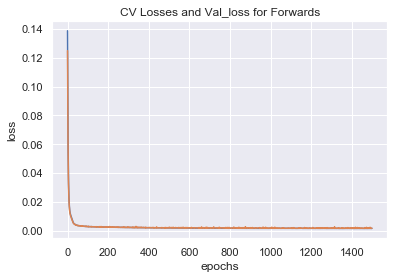

In [8]:
epochs = range(1500)
plt.plot(epochs, losses)
plt.plot(epochs, val_losses)

plt.title("CV Losses and Val_loss for Forwards")
plt.xlabel("epochs")
plt.ylabel("loss")

### Prediction

In [9]:
scaler_test = MinMaxScaler()
df_test = pd.DataFrame(input_testing_set).T
scaler_test.fit(df_test)
df_test = pd.DataFrame(scaler_test.transform(df_test)).T
input_testing_set_normalized = np.asarray(df_test)

In [10]:
predicted_set_CV_normalized = autoencoder.predict(input_testing_set_normalized)
predicted_set_CV = np.asarray(pd.DataFrame(scaler_test.inverse_transform(pd.DataFrame(predicted_set_CV_normalized).T)).T)

Text(0.5,1,'Cross Testing MSE for Repo')

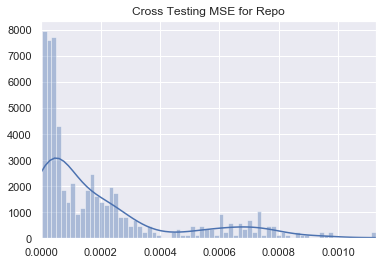

In [11]:
import seaborn as sns 
MSE_CV = np.mean((predicted_set_CV-input_testing_set)**2, axis = 1)
sns.distplot(MSE_CV, bins = 70)
plt.xlim(0,np.max(MSE_CV))
plt.title('Cross Testing MSE for Repo')

In [12]:
autoencoder_json_CV = autoencoder.to_json()
encoder_json_CV = encoder.to_json()
decoder_json_CV = decoder.to_json()

with open("../project/model/saved_model/autoencoder_CV.json", "w") as json_file:
    json.dump(autoencoder_json_CV, json_file)

with open("../project/model/saved_model/encoder_CV.json", "w") as json_file:
    json.dump(encoder_json_CV, json_file)
    
with open("../project/model/saved_model/decoder_CV.json", "w") as json_file:
    json.dump(decoder_json_CV, json_file)

    
autoencoder.save('../project/model/saved_model/autoencoder_CV.h5')
encoder.save('../project/model/saved_model/encoder_CV.h5')
decoder.save('../project/model/saved_model/decoder_CV.h5')

In [13]:
input_testing_set_normalized.shape

(531, 14)

In [14]:
predicted_set_CV_normalized.shape

(531, 14)

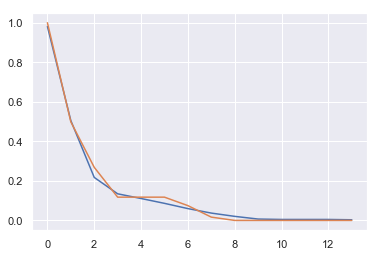

In [15]:
plt.plot(predicted_set_CV_normalized[0])
plt.plot(input_testing_set_normalized[0])

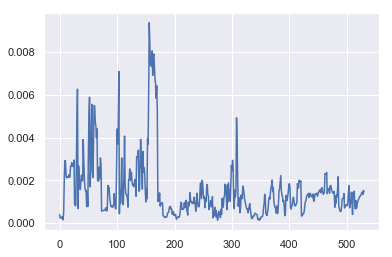

In [16]:
plt.plot(np.mean((predicted_set_CV_normalized-input_testing_set_normalized)**2, axis = 1))

In [17]:
np.argmax(np.mean((predicted_set_CV_normalized-input_testing_set_normalized)**2, axis = 1))

156

In [18]:

scaler_test.fit(df_test)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [19]:
threshold = 0.006

In [20]:
def scaleObservation(interpolatedObs, nonInterpolatedObs):
    commonMax = np.amax(interpolatedObs)#max(np.amax(interpolatedObs),nonInterpolatedObs.max()) 
    commonMin = np.amin(interpolatedObs)#min(np.amin(interpolatedObs),nonInterpolatedObs.min()) 
    return (nonInterpolatedObs - commonMin)/(commonMax - commonMin)

funcScaleObservation = lambda x : scaleObservation(x[0],x[1])
input_testing_set_orig_scaled = list(map(funcScaleObservation,
                                         list(zip(input_testing_set, input_testing_set_orig))))

In [21]:
def plotOutlier(threshold):
    indexList = np.where(np.mean((predicted_set_CV_normalized-input_testing_set_normalized)**2,axis = 1) > threshold)[0]
    unscaledValue = scaler_test.inverse_transform(input_testing_set_normalized)
    unscaledPredictedValue = scaler_test.inverse_transform(predicted_set_CV_normalized)
    for i in indexList:
        print(i)
        plt.plot(xvals, predicted_set_CV_normalized[i])
        plt.plot(xvals, input_testing_set_normalized[i],'-')
        plt.plot(input_testing_set_orig_scaled[i],'o')
        plt.show()
    return

31


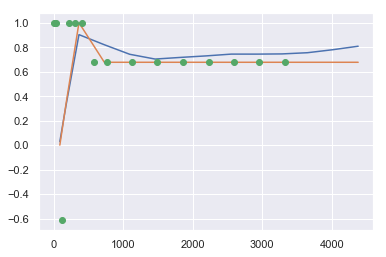

103


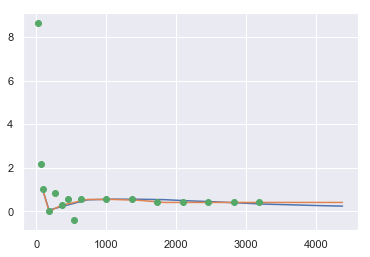

155


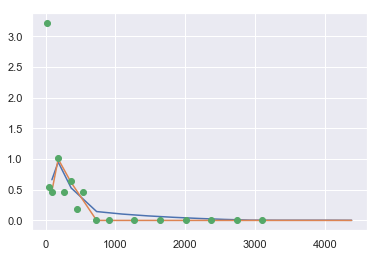

156


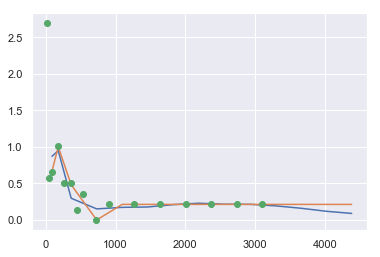

157


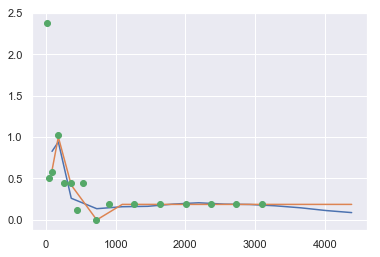

158


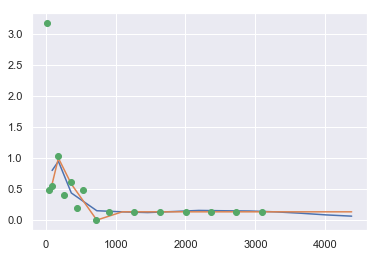

159


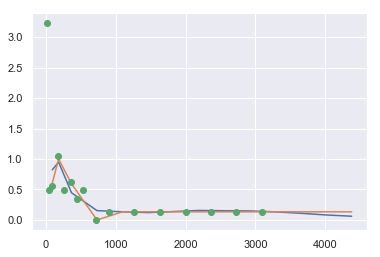

160


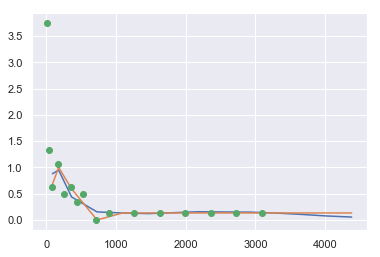

161


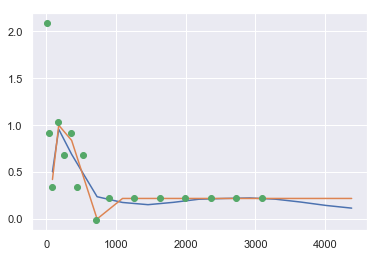

162


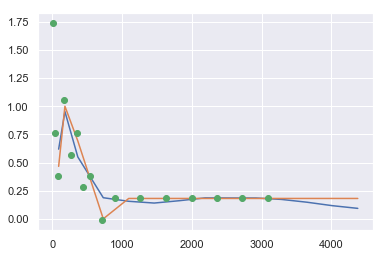

163


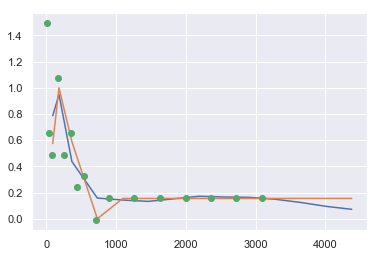

164


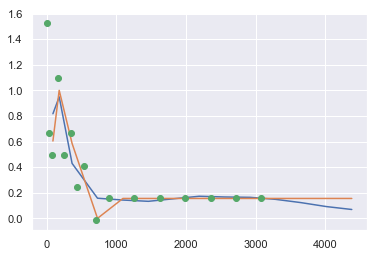

165


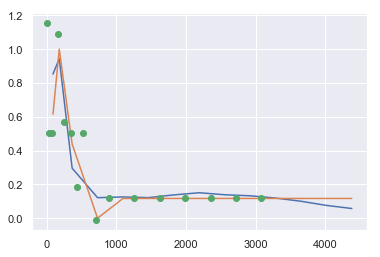

166


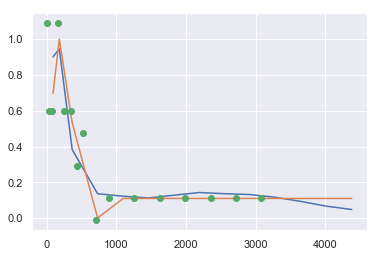

167


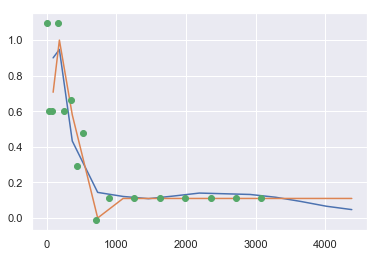

169


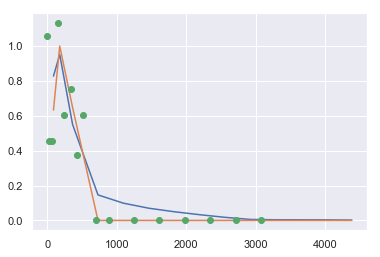

In [22]:
plotOutlier(threshold)

Pas d'utilisation possible des données originales car le format change et l'autoencodeur attend un format fixe pour un nombre fixe d'input units. 
On ne peut comparer que l'interpolation et la prédiction de l'interpolation.
On devrait alors se trouver avec une définition biaisée des outliers : l'interpolation donnera des observations bien différentes de celles observées.

Bien que les points soient nombreux dans les graphes précédents, la courbe inteporlée ne passe absolument pas par les points et la détecte comme outlier. Ces observations seraient probablement considées comme inliers avec l'approche fonctionnelle (à vérifier).

Faire attention à ne sélectionner qu'un marché précis.



In [23]:
input_testing_set

[[0.37,
  0.28476190476190477,
  0.24565217391304348,
  0.22,
  0.22,
  0.22,
  0.21271978021978022,
  0.2028301886792453,
  0.2,
  0.2,
  0.2,
  0.2,
  0.2,
  0.2],
 [0.414,
  0.2970833333333333,
  0.24652173913043476,
  0.22,
  0.22,
  0.22,
  0.21269230769230768,
  0.2028032345013477,
  0.2,
  0.2,
  0.2,
  0.2,
  0.2,
  0.2],
 [0.4,
  0.29333333333333333,
  0.24489130434782608,
  0.22,
  0.22,
  0.22,
  0.2126098901098901,
  0.202722371967655,
  0.2,
  0.2,
  0.2,
  0.2,
  0.2,
  0.2],
 [0.41828571428571426,
  0.29357142857142854,
  0.24434782608695652,
  0.22,
  0.21263736263736263,
  0.21,
  0.21,
  0.20269541778975741,
  0.2,
  0.2,
  0.2,
  0.2,
  0.2,
  0.2],
 [0.4382857142857143,
  0.2930952380952381,
  0.24380434782608695,
  0.22,
  0.2126098901098901,
  0.21,
  0.21,
  0.20266846361185983,
  0.2,
  0.2,
  0.2,
  0.2,
  0.2,
  0.2],
 [0.42957142857142855,
  0.29,
  0.24271739130434783,
  0.22,
  0.22,
  0.21252747252747253,
  0.21,
  0.2026145552560647,
  0.2,
  0.2,
  0.2,


In [24]:
input_testing_set_normalized[0]

array([1.        , 0.49859944, 0.2685422 , 0.11764706, 0.11764706,
       0.11764706, 0.07482224, 0.01664817, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [25]:
predicted_set_CV_normalized[0]

array([0.98094165, 0.50509536, 0.21749166, 0.1346212 , 0.11085426,
       0.08632976, 0.05979656, 0.03707319, 0.02048576, 0.00689102,
       0.00487741, 0.00489856, 0.00485008, 0.00330167], dtype=float32)